In [2]:
import pandas as pd
from arcgis.features import GeoAccessor
from arcgis.gis import GIS
import json
import arcpy
import requests
import os

In [6]:
class OpenDataAPI(object):
    """
    Search, download, sign in to AGOL, and publish to AGOL ArcGIS' Open Data Site data
    """
    
    def __init__(self):
        """initializer"""
        self._base_url = "https://opendata.arcgis.com/api/v3"
        self.siz = "&page%5Bsize%5D="
        self.num = "&page%5Bnumber%5D="
        self.tg = "&filter%5Btags%5D="
        
        
    def search(self, term, size, number, tag):
        """
        This allows you to search ArcGIS' Open Data Site based on the inputs and then you can pick the one wanted 
        inputs:
        term: string - search term REQUIRED
        size: integer - the number of objects to be returned OPTIONAL
        number: integer - the page number OPTIONAL
        tag: list of strings or single string - tags to be associated with search OPTIONAL
        return:
        re: json - an object that can be downloaded 
        """
        #Take search term and add to open data url
        combine = "/datasets?q=" + term
        newquery = (self._base_url + combine)
        
        #if size is given then add to open data url
        if size != "":
            newquery = (newquery + self.siz + str(size))
            
        #if number is given then add to open data url
        if number != "":
            newquery = (newquery + self.num + str(number))
            
        #if tag is given then add to open data url
        if tag != "":
            newquery = (newquery + self.tg + tag)
        
        #request and send message to user on status
        response = requests.get(newquery)
        if response:
            print('Success!')
            #rectrieve the data and place into a form that is easy to read 
            data = response.json()
            rnge = data['meta']['page']['size']
            gis = GIS()
            return_list =[]
            check_list = []
            for x in range(rnge):
                check_list.append(x)
                name = data['data'][x]['attributes']['name']
                sid = data['data'][x]['id']
                search_result = gis.content.get(sid)
                typ = data['data'][x]['type']
                return_list.append(f"RECORD {x}")
                return_list.append(search_result)
                return_list.append(f"Name: {name}, ID = {sid}, type = {typ}")
                return_list.append(" ")
            for x in return_list:
                print(x)

            #ask the user which object they would like to choose 
            specific = input("Enter RECORD # to download:")
            spec = int(specific)
            if spec in check_list:
                #return the data of the object chosen 
                re = data['data'][spec]
            else:
                re = 'Try a record that is available above'
                print(re)
        else:
            re = 'Not Found. Try again.'
            print(re)
        return re
    
    def download(self, re):
        """
        Downloads the returned data from the search function
        input:
        re: json object - the returned data from the search function
        return:
        file: file = returns the input object as a file
        """
        sid = re['id']
        gis = GIS()
        layer = gis.content.get(sid)
        file = layer.get_data()
        return file
    
    def signIn(self, url, user, pas):
        """
        Allows you to sign in to your AGOL account 
        input:
        url: string - url to AGOL site
        user: string - username
        pas: string - password
        return:
        agol_login: agol instance - This will be used if you would like to add the downloaded data to AGOL
        """
        agol_login = GIS(url, user, pas)
        print("Logged in as user to " + agol_login.properties.portalName)
        return agol_login
    
    def addtoAGOL(self, down, search, signIn):
        """
        allow users to publish data to their own ArcGIS Online and populate all the metadata
        input:
        down: return from the download function REQUIRED 
        search: return from the search function REQUIRED 
        signIn: return from the signIn function OPTIONAL
        return:
        new_item: newly published item 
        """
        title = search['attributes']['name']
        typ = search['type']
        tags = search['attributes']['tags']
        if signIn == "":
            gis = GIS('home')
            print("Logged in as anonymous user to " + gis.properties.portalName)
            new_item = gis.content.add(item_properties={'title': str(title), 'type' : typ, 'tags' : tags}, data=down)
        else:
            new_item = signIn.content.add(item_properties={'title': str(title), 'type' : str(typ), 'tags' : tags}, data=down)
        return new_item

In [8]:
s = OpenDataAPI()
#Search for the term forest, return 2 items on page 1 with no tags
search_item = s.search("forest", "2", "1", "")

#RESPOND BELOW WITH THE RECORD NUMBER YOU WANT, DO NOT CHOOSE WEB MAPS OR APPLICATIONS

Success!
RECORD 0
<Item title:"Forest_Ownership" type:Service Definition owner:gdesanker@conservationfund.org_TCF>
Name: Forest Ownership, ID = 97a1439a1ae744328f30f696f17e9946, type = dataset
 
RECORD 1
<Item title:"Forest Reserves" type:Web Map owner:omerba>
Name: Forest Reserves, ID = f3f3654dd7c340e6bd063d83d033350d, type = dataset
 
Enter RECORD # to download:0


In [9]:
downloaded_item = s.download(search_item)

In [10]:
#This may take a few minutes 
new_item = s.addtoAGOL(downloaded_item, search_item, "")

Logged in as anonymous user to ArcGIS Online


<Item title:"Forest Ownership" type:Service Definition owner:jbonifi1_GISandData>
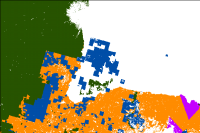

In [11]:
new_item